In [41]:
import os
import math
import numpy as np
import torch
import tqdm
import sys
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from mydataset import MyDataSet
from utils import read_split_data
from model import BetaVAE
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import ADASYN

In [43]:
torch.cuda.is_available()
tb_writer = SummaryWriter()

In [44]:
batch_size = 1
lrm = 0.002
lrf = 0.0000001
epochs = 100

In [45]:
label = np.load("../MicSigV1_jsn/MicSigV1/test_label.npy")
spec = np.load("../MicSigV1_jsn/MicSigV1/test_spec.npy")
waveform = np.load("../MicSigV1_jsn/MicSigV1/test_waveform.npy")

tensor_label = torch.Tensor(label)
tensor_spec = torch.Tensor(spec)
tensor_spec = torch.unsqueeze(tensor_spec,dim=1)
tensor_waveform = torch.Tensor(waveform)

my_dataset = TensorDataset(tensor_spec,tensor_label)

In [46]:
device = torch.device(args.device if torch.cuda.is_available() else "cpu")
# tb_writer = SummaryWriter()

In [47]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 4])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

Using 0 dataloader workers every process


In [48]:
train_loader = torch.utils.data.DataLoader(my_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw)

# val_loader = torch.utils.data.DataLoader(val_dataset,
#                                          batch_size=batch_size,
#                                          shuffle=False,
#                                          pin_memory=True,
#                                          num_workers=nw,
#                                          collate_fn=val_dataset.collate_fn)

In [49]:
# from PIL import Image
# img = Image.open('/Users/tanx/mtetna/MicSigV1/MicSigV1_jsn/MicSigV1/V1_jpg/HB/HB1082.jpg')
# print(img)
# ig = np.load('/Users/tanx/mtetna/MicSigV1/MicSigV1_jsn/MicSigV1/V1_spec_no_nl/HB/HB1082.npy')
# ig.shape
# # training = np.load(train_images_path[0]).reshape
# print((Image.fromarray(ig)).size)


In [50]:
model = BetaVAE(in_channels = 1,
                latent_dim = 20,
                hidden_dims = [4, 8, 16, 32],
                loss_type = 'H',
                input_size=(32,64))
summary(model, (1, 32, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 64]               4
       BatchNorm2d-2            [-1, 4, 32, 64]               8
              GELU-3            [-1, 4, 32, 64]               0
            Conv2d-4            [-1, 4, 32, 64]             144
       BatchNorm2d-5            [-1, 4, 32, 64]               8
              GELU-6            [-1, 4, 32, 64]               0
            Conv2d-7            [-1, 4, 32, 64]             144
       BatchNorm2d-8            [-1, 4, 32, 64]               8
              GELU-9            [-1, 4, 32, 64]               0
    Encoder_block-10            [-1, 4, 32, 64]               0
        MaxPool2d-11            [-1, 4, 16, 32]               0
           Conv2d-12            [-1, 8, 16, 32]              32
      BatchNorm2d-13            [-1, 8, 16, 32]              16
             GELU-14            [-1, 8,

In [51]:
pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(pg, lr=lrm, weight_decay=5E-5)
# Scheduler https://arxiv.org/pdf/1812.01187.pdf
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (lrm - lrf) + lrf  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

In [52]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    
    kld_loss = torch.zeros(1).to(device)  # 累计损失
    recon_loss = torch.zeros(1).to(device)
    accu_total_loss = torch.zeros(1).to(device)
    optimizer.zero_grad()
    
    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        recons, inputs, mu, log_var = model.forward(images)
        train_loss = model.loss_function(recons, inputs, mu, log_var, M_N = 0) #al_img.shape[0]/ self.num_train_imgs)
        total_loss = train_loss['loss']
        accu_total_loss += total_loss.detach()
        recon_loss += train_loss['Reconstruction_Loss'].detach()
        kld_loss += train_loss['KLD'].detach()

        total_loss.backward()

        data_loader.desc = "[train epoch {}] loss: {:.5f}, kld: {:.5f}, recon: {:.5f}".format(epoch,
                                                                               accu_total_loss.item() / (step + 1),
                                                                               kld_loss.item() / (step + 1),
                                                                               recon_loss.item() / (step + 1))
        if not torch.isfinite(total_loss):
            print('WARNING: non-finite loss, ending training ', total_loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_total_loss.item() / (step + 1), kld_loss.item() / (step + 1), recon_loss.item() / (step + 1)

In [53]:
# data_loader = tqdm(train_loader, file=sys.stdout)
for epoch in range(epochs):
    # train
    total_loss, kld_loss, recon_loss = train_one_epoch(model=model,
                                            optimizer=optimizer,
                                            data_loader=train_loader,
                                            device=device,
                                            epoch=epoch)
    scheduler.step()
    
    tags = ["total_loss", "kld_loss", "recon_loss", "learning_rate"]
    tb_writer.add_scalar(tags[0], total_loss, epoch)
    tb_writer.add_scalar(tags[1], kld_loss, epoch)
    tb_writer.add_scalar(tags[2], recon_loss, epoch)
    tb_writer.add_scalar(tags[3], optimizer.param_groups[0]["lr"], epoch)
torch.save(model.state_dict(), "./weights/model_3264_noaug_100_latent20_sto_AE-{}.pth".format(epoch))

[train epoch 0] loss: 1.01508, kld: 40.64556, recon: 1.01508: 100%|█| 11870/1187
[train epoch 1] loss: 0.83787, kld: 103.69404, recon: 0.83787: 100%|█| 11870/118
[train epoch 2] loss: 0.74594, kld: 128.53293, recon: 0.74594: 100%|█| 11870/118
[train epoch 3] loss: 0.61108, kld: 140.23112, recon: 0.61108: 100%|█| 11870/118
[train epoch 4] loss: 0.45824, kld: 143.75557, recon: 0.45824: 100%|█| 11870/118
[train epoch 5] loss: 0.37527, kld: 145.69411, recon: 0.37527: 100%|█| 11870/118
[train epoch 6] loss: 0.33507, kld: 147.50135, recon: 0.33507: 100%|█| 11870/118
[train epoch 7] loss: 0.31791, kld: 148.96381, recon: 0.31791: 100%|█| 11870/118
[train epoch 8] loss: 0.30777, kld: 150.44852, recon: 0.30777: 100%|█| 11870/118
[train epoch 9] loss: 0.30002, kld: 151.21675, recon: 0.30002: 100%|█| 11870/118
[train epoch 10] loss: 0.29395, kld: 152.18586, recon: 0.29395: 100%|█| 11870/11
[train epoch 11] loss: 0.28897, kld: 153.31942, recon: 0.28897: 100%|█| 11870/11
[train epoch 12] loss: 0.284

In [13]:
iterator = iter(train_loader)
images, label = next(iterator)
recons, inputs, mu, log_var = model.forward(images)


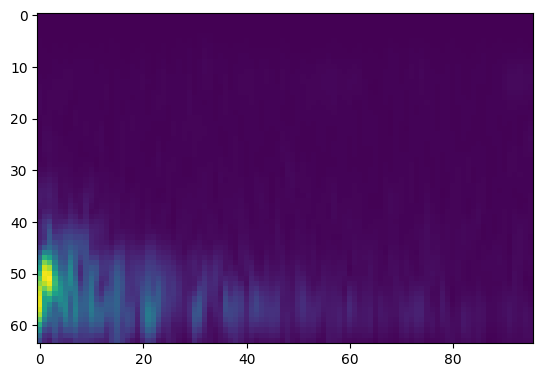

In [21]:
plt.imshow(images[7].squeeze(dim=0).cpu().detach().numpy())

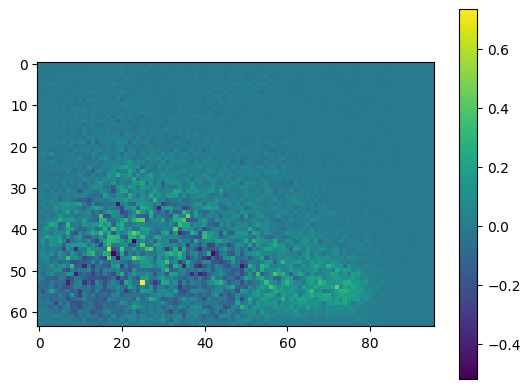

In [22]:

plt.imshow((recons[2]-recons[0]).squeeze(dim=0).cpu().detach().numpy())
plt.colorbar()

In [1]:
def evaluate(images, recons, idx):
    image = images[idx]
    image_recon = recons[idx]
    img = (torch.squeeze(image, dim=0)).cpu().detach().numpy()
    img_recon = (torch.squeeze(image_recon, dim=0)).cpu().detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    ax[0].imshow(img)
    ax[1].imshow(img_recon)

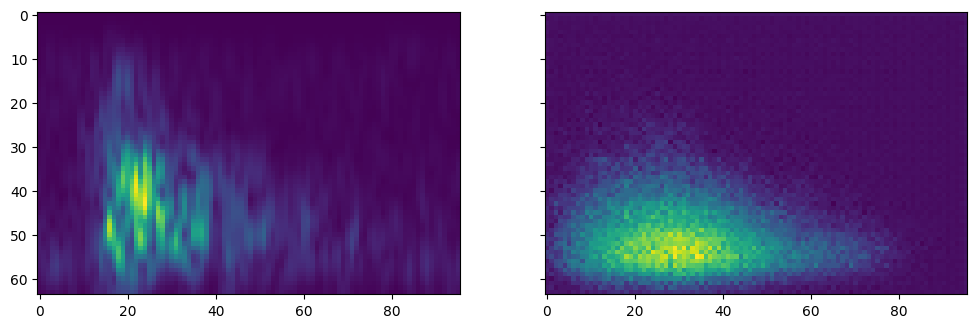

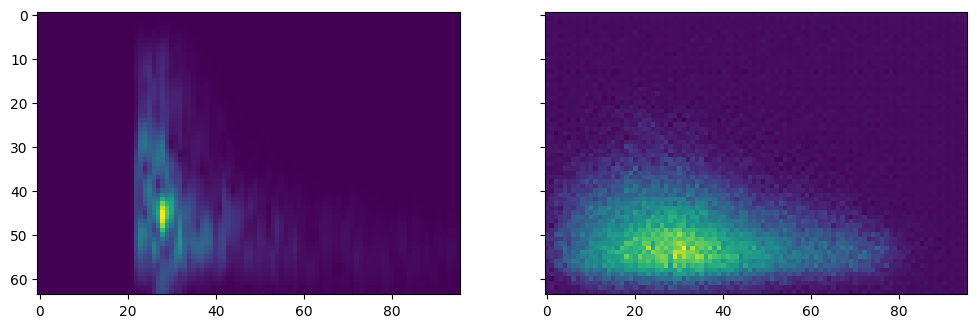

In [27]:
evaluate(inputs, recons, 0)
evaluate(inputs, recons, 12)